# CSCI 3352 Biological Networks, Spring 2020, Prof. Clauset
Submit here: https://moodle.cs.colorado.edu/course/view.php?id=1273

# Problem Set 7 : Network epidemiology


***

**Name**: Julia Sanford

**Worked with**: Denver Chernin

***

This assignment is due on Moodle by **11:55pm on Friday, March 13th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 65 points total, and 20 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Moodle.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import copy
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def plot_epidemicDynamics(St,It,Rt):
    # DO NOT MODIFY THIS FUNCTION
    # This function plots the S(t),I(t),R(t) time series nicely
    # WARNING: function is optimistic: assumes inputs are properly formatted

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(len(St)), St, 'bo-', alpha=0.5,label='S(t)')  # plot the S(t) time series
    plt.plot(range(len(It)), It, 'rv-', alpha=0.5,label='I(t)')  # plot the I(t) time series
    plt.plot(range(len(Rt)), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the R(t) time series
    plt.ylabel('number of nodes')
    plt.xlabel('time, t')
    plt.legend(loc='upper right');
    #ax1.set_xlim([0, 50])
    plt.show()
    return

***
## Part 1 (10 pts) : Warming up

* Using the SIR simulation code from the in-class lab, write a function `run_SIR(G,s,beta,gmma,flag)` that
  * takes as input a simple `networkx` graph, an integer `s` that specifies the _number_ of randomly chosen infected nodes at time $t=0$, choices of $\beta$ and $\gamma$, and a binary variable `flag` (`=0` means run silently; `=1` means display any intermediate outputs, like `drawGz()` or `print()` statements),
  * runs the simulation to its completion, and then
  * returns the $S(t)$, $I(t)$, $R(t)$ time series for the progression of the epidemic (for plotting using the `plot_epidemicDynamics()` function) _and_ a dictionary `xt` that stores for each node `i` the corresponding time `t` at which `i` became infected. You'll need to instrument the existing simulation code to track `xt` correctly.
  
* Then, apply your new function to the toy graph from the lecture notes and lab, with $s=1$ and $\beta=\gamma=0.3$, and plot the resulting time series.

In [4]:
def run_SIR(G,s,beta,gmma,flag):
    # Basic SIR simulation    
    # YOUR CODE

    # create a partition list initialized as 'S' and a list of when each node gets infected initialized to t = 0
    n = G.order()
    zt = dict.fromkeys(range(n), 'S')
    xt = dict.fromkeys(range(n), 0)
    # randomly choose s nodes to start infected and set their status and time infected
    infected = np.random.choice(n, s)
    for k in zt.keys():
        if (k in infected):
            zt[k] = 'I'
            xt[k] = 1

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    t = 1
    if (flag == 1): # if flag print and draw
        print(f'time step {t}')
        drawGz(G,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    
    # same as in-class SIR experiment but with xt assignments
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() < beta:
                    zu[j] = 'I'       # i infects j for next round
                    xt[j] = t         # node j gets infected at time t
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() < beta:
                    zu[i] = 'I'       # j infects i for next round
                    xt[i] = t         # node j gets infected at time t
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G.nodes():
            if zt[i] == 'I' and rnd.random() < gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1
        if (flag == 1):
            print(f'time step {t}')
            drawGz(G,zt)

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    return St,It,Rt,xt

time step 1


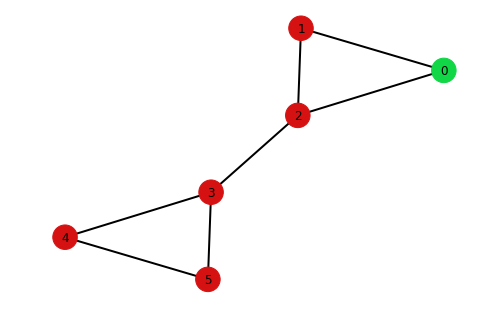

time step 2


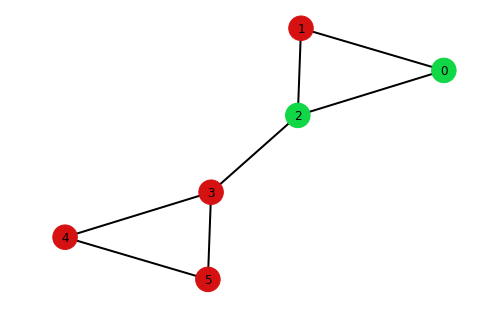

time step 3


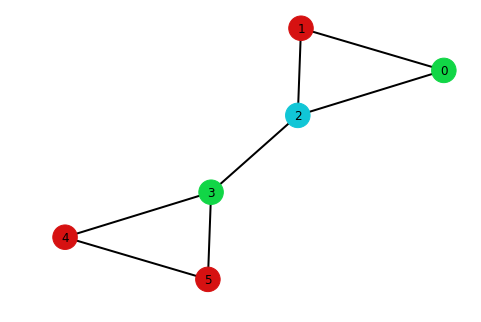

time step 4


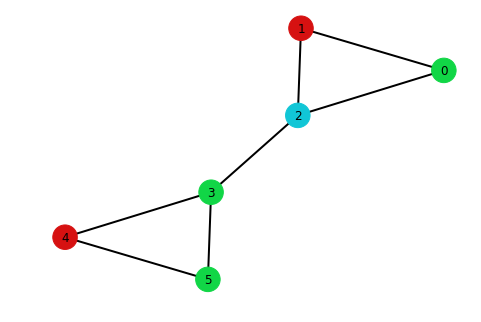

time step 5


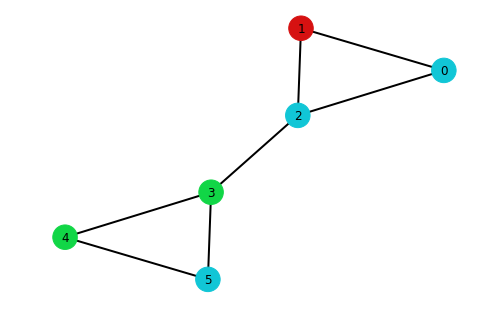

time step 6


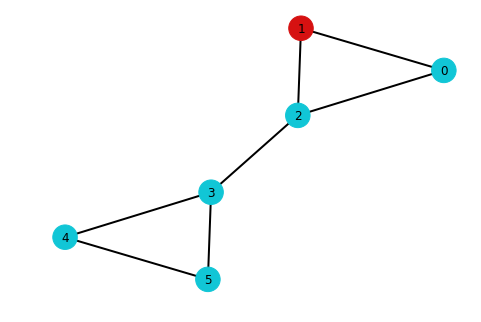

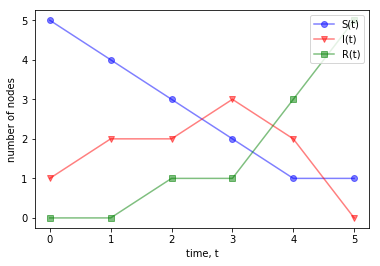

In [5]:
##### do not modify below here #####
##    run this code once you've written the run_SIR() function

G  = nx.Graph([(0,1),(0,2),(1,2),(2,3),(3,4),(3,5),(4,5)]) # a simple graph G

beta = 0.3
gmma = 0.3
flag = 1

St,It,Rt,xt = run_SIR(G,1,beta,gmma,flag)
plot_epidemicDynamics(St,It,Rt)

##### do not modify above here #####

***
## Problem 2 : The role of the degree distribution (55 pts total)

In this problem, you will investigate the role of the exposure graph's degree distribution $\Pr(k)$ on an epidemic's dynamics $I(t)$. This problem has three parts:
* `Problem 2-A`, you'll generate high/medium/low variance degree distributions.
* `Problem 2-B`, you'll run an epidemic on each and discuss the differences.
* `Problem 2-C`, you'll investigate the role of degree on _when_ a node gets infected.

### Problem 2-A (20 pts)

In `Problem 2-B` we'll use the Chung-Lu model to generate random graphs with a specified degree distribution. However, to see how varying the degree structure changes the epidemic's shape, we'll first need a low-dimensional way to vary the degree structure's shape. There are many ways to do this. Here, we'll use a 2-parameter distribution called a *stretched exponential*, which has the form:

<br/>
<center>$\Pr(x) \propto x^{\beta-1} \textrm{exp}(-\lambda \, x^{\beta})$,</center>

where $\beta\geq 0$ and $\lambda\geq 0$. When $\beta=1$, this distribution returns a standard (low variance) exponential distribution with parameter $\lambda$; when $\beta=2$, it decays like a standard (lower variance) Gaussian or Normal distribution; and when $\beta<1$, it decays more slowly than an exponential (higher variance). The parameter $\lambda$ is inversely related to the mean degree, so that $\lambda<1$ means a higher mean, and $\lambda>1$ means a lower mean.

* Use the provided function `drawFrom_SE(n,beta,lmbda)` to generate *three* lists, each containing $n=1000$ values. The three lists should be generated with different combinations of $\beta$ and $\lambda$, and should meet the following criteria:
  * one distribution should have "low" variance, one should have "high" variance, and one should be in between those, and
  * they should all have the roughly the same average value (e.g., in my solutions, the mean is about $2.3\pm0.1$).
* Modify the `plot_2CCDF()` function from `Problem Set 2` to display all three of these distributions together, i.e., make and apply a function `plot_3CCDF()`.
* Briefly describe the effect of increasing or decreasing $\beta$ and $\lambda$ on the shape of the plotted distributions, e.g., on the shape of the "body" (the middle part) and the upper tail of the distribution.

Hint: You will likely need to fiddle with different choices of parameters in order to find good settings. Try starting at $\beta=\lambda=1$, and then increasing or decreasing one, then the other parameter, until you get something reasonable when you plot it. For the "high" variance distribution, you'll want the maximum value you generate to be no higher than 100 or so.

In [6]:
def drawFrom_SE(n,beta,lmbda):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws n values from a stretched exponential distribution with parameters beta,lambda
    # and then rounds them to integers for use as degrees. It returns these in a list x.

    xmin = 0.5  # minimum value 
    x    = [] # 
    for i in range(n):
        xi = int(round( (xmin**beta - (1/lmbda)*np.log(1-rnd.random()))**(1/beta) ))
        x.append(xi)

    return x

In [7]:
def plot_3CCDF(kis1,kis2,kis3):
    # input : three lists of degrees
    # output: one plot showing the CCDFs of the three degree distributions Pr(K>=k) for k>=1
    
    # YOUR CODE
    kis1_max = max(kis1)
    kis2_max = max(kis2)
    kis3_max = max(kis3)

    # histograms
    icounts, ibins = np.histogram(kis1, bins=[i for i in range(kis1_max+2)], density=True)
    icumcounts = np.cumsum(icounts)
    icumcounts = np.insert(icumcounts,0,0)
    ocounts, obins = np.histogram(kis2, bins=[i for i in range(kis2_max+2)], density=True)
    ocumcounts = np.cumsum(ocounts)
    ocumcounts = np.insert(ocumcounts,0,0)
    acounts, abins = np.histogram(kis3, bins=[i for i in range(kis3_max+2)], density=True)
    acumcounts = np.cumsum(acounts)
    acumcounts = np.insert(acumcounts,0,0)

    # plots
    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.loglog(ibins[1:-1], 1-icumcounts[1:-1], 'ro', alpha=0.5, label='kis1')
    plt.loglog(obins[1:-1], 1-ocumcounts[1:-1], 'bo', alpha=0.5, label='kis2')
    plt.loglog(abins[1:-1], 1-acumcounts[1:-1], 'go', alpha=0.5, label='kis3')
    plt.title('CCDF, in- and out-degrees (loglog)')
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.legend(loc='upper right');
    plt.show()
    return

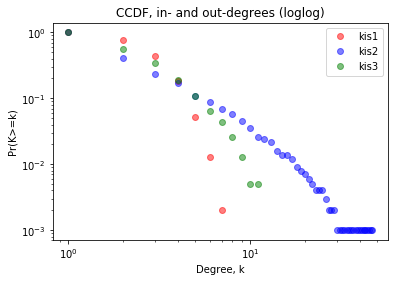

x1, mean = 2.445
x2, mean = 2.427
x3, mean = 2.362


In [8]:

# YOUR CODE
# set beta values as 2, 0.3, and 1 and set lambda values to make the averages 2.3
n = 1000

beta1 = 2
lmbda1 = 0.15

beta2 = 0.3
lmbda2 = 3

beta3 = 1
lmbda3 = 0.55

##### do not modify below here #####
##    run this code once you've written the plot_3CCDF() function

x1 = drawFrom_SE(n,beta1,lmbda1)
x2 = drawFrom_SE(n,beta2,lmbda2)
x3 = drawFrom_SE(n,beta3,lmbda3)

plot_3CCDF(x1,x2,x3)

print(f'x1, mean = {sum(x1)/n}')
print(f'x2, mean = {sum(x2)/n}')
print(f'x3, mean = {sum(x3)/n}')

Increasing $\beta$ and therefore decreasing $\lambda$ (shown in red) caused the degrees to trail off at much lower values, so overall, the degrees of the nodes would be smaller than that of a lower $\beta$ because there is a lower variance in the degrees. Decreasing $\beta$ and therefore increasing $\lambda$ (shown in blue) cause the degrees to have a high variance and dropped off later because there is a large difference in the degrees of each node, so some have smaller and some have larger. A $\beta$ of 1 is middle variance (shown in green) and falls somewhere in the middle of the two.

### Problem 2-B (15 pts)

Now, using $\beta=\gamma=0.4$ (at the critical threshold of $R_0$):
* Use the built-in `networkx` Chung-Lu graph generator to make a graph for each of your three degree distributions.
* Then, run your SIR simulation on each graph, and plot the corresponding epidemic's dynamics.
* Discuss what you see as differences or similarities among or between the three cases, and offer an explanation _in terms of the role that node degree plays in spreading the epidemic_. Remember that the _only_ thing different about these three graphs is the degree structure. (You may find it useful to use `drawGz()` to visualize them.)

Hint: You may need to re-run the simulation on the same graphs multiple times in order to get three good runs (since each run will start the epidemic in a different location, and occasionally the epidemic may not take off). Alternatively, you can increase the number of initially infected nodes to a small integer (maybe 5 at most). When comparing epidemics, don't forget to look at how _long_ they last.

Beta = 2, Lambda = 0.15, Low Variance


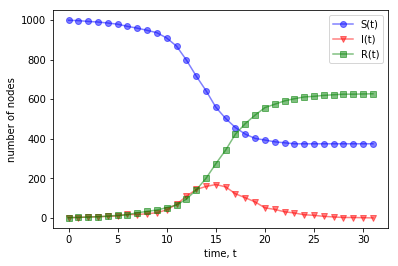

Beta = 0.3, Lambda = 3, High Variance


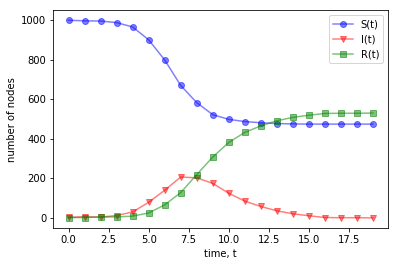

Beta = 1, Lambda = 0.55, Middle Variance


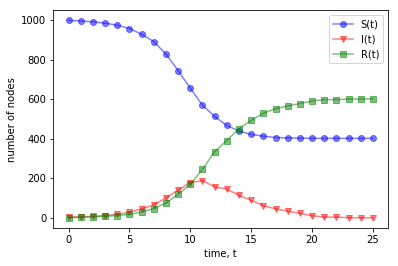

In [10]:
# YOUR CODE
# set beta and gamma
beta = 0.4
gamma = 0.4

# create a Chung-Lu graph for each beta-lmbda pair
CLG1 = nx.expected_degree_graph(x1, selfloops=False)
CLG2 = nx.expected_degree_graph(x2, selfloops=False)
CLG3 = nx.expected_degree_graph(x3, selfloops=False)

# run the SIR for each beta-lmbda pair Chung-Lu graph and plot St, It, and Rt
St1,It1,Rt1,xt1 = run_SIR(CLG1,3,beta,gamma,0)
print("Beta = 2, Lambda = 0.15, Low Variance")
plot_epidemicDynamics(St1,It1,Rt1)

St2,It2,Rt2,xt2 = run_SIR(CLG2,3,beta,gamma,0)
print("Beta = 0.3, Lambda = 3, High Variance")
plot_epidemicDynamics(St2,It2,Rt2)

St3,It3,Rt3,xt3 = run_SIR(CLG3,3,beta,gamma,0)
print("Beta = 1, Lambda = 0.55, Middle Variance")
plot_epidemicDynamics(St3,It3,Rt3)

The first graph is where $\beta = 2$ and $\lambda = 0.15$ which means this is a very low variance for degree distribution. In this graph, most nodes have similar degrees; therefore, each node has about the same likelihood of getting infected and infecting other people. The spread of the disease will be pretty even across the graph and take some time to reach most or all of the people.

The second graph is where $\beta = 0.3$ and $\lambda = 3$ which means this is a very high variance for degree distribution. In this graph, some nodes will have very high degrees while others have very small degrees. This means that those with higher degrees have a much higher likelihood of getting infected and infecting other people. The spread of the disease will be pretty quick and will not take a lot of time to spread to most or all of the people.

The third graph is where $\beta = 1$ and $\lambda = 0.55$ which means this is a normal low variance for degree distribution. In this graph, the nodes have a normal distribution of nodes. This means that most nodes have a similar number of degrees while there are some outliers that have very low or very high degrees. The spread of the disease is in between the first two graphs where in some places it will travel slowly where degrees are small or equal, and it will travel more quickly in areas of high degrees. It will take a time in between the first two graphs to reach most or all of the people.

### Problem 2-C (20 pts)

High degree nodes, which are more common under high variance degree distributions, play a special role in epidemics. Let's investigate.
* Using the `xt` output variable from your `run_SIR()` function, make three scatter plots of the time of infection $t_i$ as a function of node degree $k_i$, one for each network.
* For each plot, calculate and report the correlation coefficient `r = np.corrcoef(x,y)[0,1]` between your $x$ and $y$ variables.
* Finally, discuss any patterns you see within and across your high/medium/low variance networks from this perspective, and use the correlation coefficients you calculate to offer an explanation (in terms of the network structure and the rules of the SIR epidemic) as to why that pattern exists.

Hint: Don't plot values where $t_i=-1$, which is a special value indicating that node $i$ was never infected.

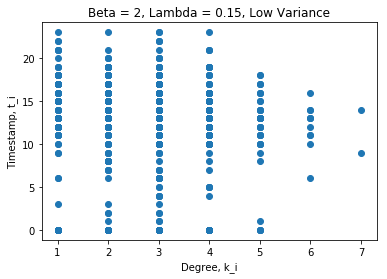

Correlation coefficient:  0.25993708361983126


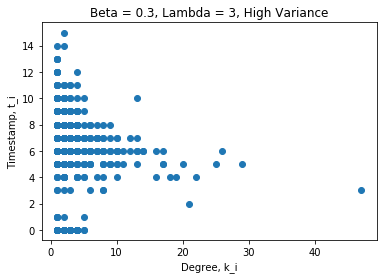

Correlation coefficient:  0.18790666673696702


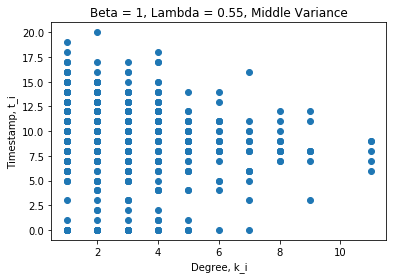

Correlation coefficient:  0.246103868669402


In [17]:
# YOUR CODE

# plot the degree vs time of infection graphs and calculate the correlation coefficient for each beta-lmbda graph

plt.scatter(x1, xt1.values())
plt.title("Beta = 2, Lambda = 0.15, Low Variance")
plt.xlabel("Degree, k_i")
plt.ylabel("Timestamp, t_i")
plt.show()
r1 = np.corrcoef(x1,list(xt1.values()))[0,1]
print("Correlation coefficient: ", r1)

plt.scatter(x2, xt2.values())
plt.title("Beta = 0.3, Lambda = 3, High Variance")
plt.xlabel("Degree, k_i")
plt.ylabel("Timestamp, t_i")
plt.show()
r2 = np.corrcoef(x2,list(xt2.values()))[0,1]
print("Correlation coefficient: ", r2)

plt.scatter(x3, xt3.values())
plt.title("Beta = 1, Lambda = 0.55, Middle Variance")
plt.xlabel("Degree, k_i")
plt.ylabel("Timestamp, t_i")
plt.show()
r3 = np.corrcoef(x3,list(xt3.values()))[0,1]
print("Correlation coefficient: ", r3)

For the low and middle variance, there is some but a low positive correlation between the degree and timestamp of infection. This means that while most nodes have around the same degree, as the degree increases, so does the time it takes for the infection to reach you. The high variance has a lower correlation. This makes sense because as you have more variance, there are more nodes with higher degrees. This would make the correlation less positive because it should be as you increase your degree, you would get infected faster because you could get infected from more people. 

***
### Problem 2-D (*10 pts extra credit*) : Flattening an epidemic

Complete this section of the in-class lab.

Using your SIR simulation, conduct the following three mini-experiments. For these, use the built-in `.gnp_random_graph(n, p)` network generator in `networkx`. Recall that `p` is the probability that an edge exists, and we choose it by first choosing the _mean degree_ $c$ (see Lecture Notes 3). The idea here is that the first experiment sets up your baseline for an SIR epidemic on a network, and then we'll first vary one parameter, and then vary a different parameter, to investigate the effects these parameters have on the dynamics of the epidemic. To do this, you'll want to plot the $S(t)$, $I(t)$, $R(t)$ functions after each simulation.

Experiment 3.1: simulate a basic epidemic:
* set $n=200$ and $c=6$
* note around what time step $I(t)$ peaks, and how many time steps it mostly spans.

Experiment 3.2: simulate the effect of reduced transmission (e.g., hand washing!):
* lower $\beta$; keep $\gamma$ the same, $n=200$ and $c=6$

Experiment 3.3: simulate the effect of "social distancing" (e.g., self-quarantine, staying at home, etc.):
* lower $c$ in $G(n,p)$; keep $\beta=\gamma$, $n=200$

As before, you'll want to run each setting several times to get a sense of what the epidemic tends to do. Start by lowering $\beta$ and $c$ only a little, and then keep lowering them until you see something change. Then, discuss with your teammates what you found, and answer the following specific questions:
1. What effect does lowering $\beta$ (reducing the likelihood of transmission) have on $I(t)$, compared to experiment 3.1? How much reduced transmission would you need _everyone_ to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?
* What effect does lowering $c$ (reducing the likelihood of transmission) have on $I(t)$?, compared to experiment 3.1? How much social distancing would you need_everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical $c$ might be for _you_ during a normal day. Is $c=6$ realistic?)
* Which has a larger effect on $I(t)$, reduced transmission or social distancing?

Experiment 3.1:
I(t) peaks at: 7
It spans 20 time steps.


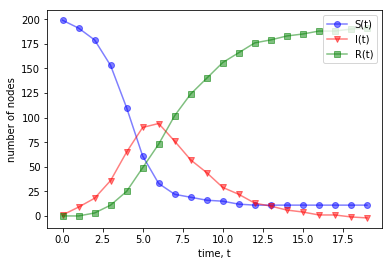

Experiment 3.2:


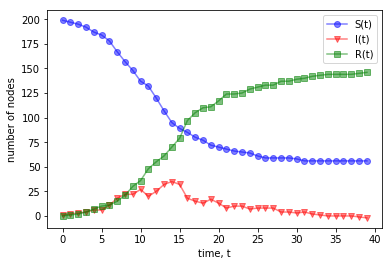

Experiment 3.3:


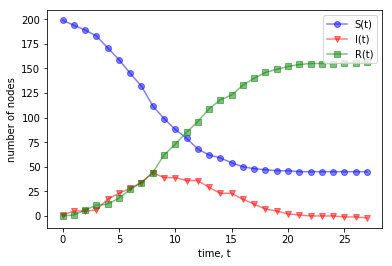

In [39]:
# YOUR CODE
# set initial variables
n = 200
c = 6
beta = 0.3
gamma = 0.3

# create a gnp random graph, 
# run SIR
# find the max I(t) and total t,
# print and plot
print("Experiment 3.1:")
G = nx.gnp_random_graph(n, (c/(n-1)))
St,It,Rt,xt = run_SIR(G,3,beta,gamma,0)
max_I = It.index(max(It)) + 1
time_steps = len(It)
print(f"I(t) peaks at: {max_I}\nIt spans {time_steps} time steps.")
plot_epidemicDynamics(St,It,Rt)

# set beta to new value,
# create gnp random graph,
# run SIR and plot
print("Experiment 3.2:")
beta = 0.1
G = nx.gnp_random_graph(n, (c/(n-1)))
St,It,Rt,xt = run_SIR(G,3,beta,gamma,0)
plot_epidemicDynamics(St,It,Rt)

# reset beta to new value,
# reduce c value,
# create gnp random graph,
# run SIR and plot
print("Experiment 3.3:")
beta = 0.3
c = 3
G = nx.gnp_random_graph(n, (c/(n-1)))
St,It,Rt,xt = run_SIR(G,3,beta,gamma,0)
plot_epidemicDynamics(St,It,Rt)

1. What effect does lowering $\beta$ (reducing the likelihood of transmission) have on $I(t)$, compared to experiment 3.1? How much reduced transmission would you need _everyone_ to do to achieve a real "flattening" of the epidemic? Do you think that's realistic?
    - Lowering $\beta$ lowers the max number of infected people at one time; however, it does make the time of the last person to recover to be later than that of in experiment 3.1. You would need to reduce transmission a lot considering that $\beta$ is already very low, 0.2 lower, in this example, but the peak is only lowered by about a quarter of the first experiment. You would need to lower it by a lot more to reduce the peak even more. This is not very realistic because you cannot expect that all humans would wash their hands perfectly and often to lower it to this standard.

2. What effect does lowering $c$ (reducing the likelihood of transmission) have on $I(t)$?, compared to experiment 3.1? How much social distancing would you need_everyone_ to do to achieve the results you found in experiment 3.3? (Consider what a typical $c$ might be for _you_ during a normal day. Is $c=6$ realistic?)
    - Lowering $c$ has the same effect as lowering $\beta$ because it reduces the probability that there is an edge between two nodes which is equivalent to social distancing because the nodes would have smaller degrees. You would need everyone to have a lot of social distancing because even with a $c$ of 3, you still only reduce the number of infected to about a quarter which is good but still a lot. You would probably need to lower $c$ to 1 or 2 to flatten the curve even more.

3. Which has a larger effect on $I(t)$, reduced transmission or social distancing?
    - Reduced transmission and social distancing have the same effect on the max value of infected people at one time; however, social distancing decreases the time that the nodes become infected and the last infected node recovers.

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
T.P. Peixoto, **Efficient Monte Carlo and greedy heuristic for the inference of stochastic block models.** Phys. Rev. E 89, 012804 (2014)
<br/>


* *What was the research question?*<br/>
The research was based on how they could create an efficient algorithm for predicting stochastic block models for large networks without interferring noise and other heuristics. They also claim that this algorithm produces the same type of results as the Markov chain Monte Carlo method, but it is faster and better. 
<br/>

* *What was the approach the authors took to answer that question?*<br/>
They began by discussing a stochastic block model and how that partitions the graphs with a set B value. Then, they explain the current Markov chain Monte Carlo method and how this approach handles large networks and splitting the nodes into a large number of partitions. They also discussed how this method is applied and how it is slow. 
<br/>

* *What did they do well?*<br/>
They did a good job of setting up the paper to explain each part individually and build up to their main point. I like how it started with simple SBMs, then applied that to the MCMC method, then applied both of those to their faster, better method. 
<br/>

* *What could they have done better?*<br/>
They could have compared this algorithm to others similar to the MCMC method. They only used the MCMC method to compare because that's the only one that they based it off of and were trying to better; however, it could be useful to compare it to other kinds of SBMs or other heuristics used to prove that their algorithm is best and not just a better version of something else that is out there.
<br/>

* *What extensions can you envision?*<br/>
They could improve this method to fix the things that it did not completely replicate from the MCMC method. For example, they say that their heuristic "does not fully saturate the detectability range of the MCMC method", so they could work on updating their method to be better while also including everything good from the MCMC methods. 